<h1>THIS NOTEBOOK COVERS</h1>
    
<h3><ol>
<li><a href="#eda">EDA</a></li>
<li><a href="#feature_selection">Feature Selection</a></li>
<li><a href="#smote">Handling Imbalanced Class Problem With SMOTE</a></li>
<li><a href="#rf">Training RandomForestClassifier & Hyperparameter Tuning With GridSearchCV</a></li>
<li><a href="#lc">Identifying Overfitting With Learning Curve</a></li>
<li><a href="#oof">Overcoming Overfitting</a></li>    

RandomForestClaasifier is an ensemble machine learning algorithm which uses a technique called bootstrap aggregation (aka bagging). Bootstrapping is a statistical technique of drawing multiple random samples of size 'k' with replacement. Aggregation refers to combining the prediction of multiple models.

Random Forests work by drawing multiple samples from the training set and build multiple models and average their predictions to give a final prediction.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from imblearn.over_sampling import SMOTE 
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve, plot_precision_recall_curve

In [2]:
src = pd.read_csv("./data_src/heart_failure_data.csv")

<a id="eda"></a><h1>EDA</h1>

In [3]:
src.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
src.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

Below we see the percentage of missing values per column. The dataset has no missing values

In [5]:
src.isnull().mean()

age                         0.0
anaemia                     0.0
creatinine_phosphokinase    0.0
diabetes                    0.0
ejection_fraction           0.0
high_blood_pressure         0.0
platelets                   0.0
serum_creatinine            0.0
serum_sodium                0.0
sex                         0.0
smoking                     0.0
time                        0.0
DEATH_EVENT                 0.0
dtype: float64

In [6]:
src.shape

(299, 13)

In [7]:
src["DEATH_EVENT"].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

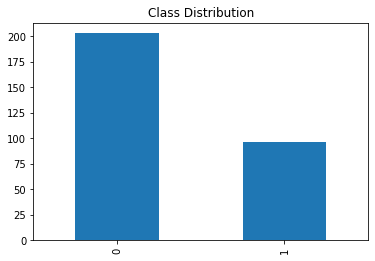

In [8]:
src["DEATH_EVENT"].value_counts().plot(kind="bar")
plt.title("Class Distribution");

<h3>The class/label is moderately imbalanced, with 68% of the classes pointing to 0. If I build a baseline model without need of any training, say y_hat = src["DEATH_EVENT"].mode(), I'd get an accuracy of 68%.</h3>


<h3>A class is said to be imbalanced if a single category dominates another catrgory. In this case '0' appears 203 times while '1' appears just 96 times.</h3>

<h3>To overcome the problem of imbalanced class, we'll try SMOTE which will be discussed later.</h3>

In [9]:
# Storing categorical and numerical features names in different Series
cat_features = ["anaemia","diabetes","high_blood_pressure","sex","smoking","DEATH_EVENT"]
num_features = pd.Series(src.columns)
num_features = num_features[~num_features.isin(cat_features)]

Crosstabs/contingency tables are one of the best ways to see how categorical variables are distributed among each other.

Chi-square test is a statistical technique to test a relationship betwen two categorical variables. The chi-square tests below shows no categorical variable has a relationship with the target variable.

In [10]:
for i in cat_features:
    ct = pd.crosstab(columns=src[i],index=src["DEATH_EVENT"])
    stat, p, dof, expected = chi2_contingency(ct) 
    print(f"\n{'-'*len(f'CROSSTAB BETWEEN {i.upper()} & DEATH_EVENT')}")
    print(f"CROSSTAB BETWEEN {i.upper()} & DEATH_EVENT")
    print(f"{'-'*len(f'CROSSTAB BETWEEN {i.upper()} & DEATH_EVENT')}")
    print(ct)
    print(f"\nH0: THERE IS NO RELATIONSHIP BETWEEN DEATH_EVENT & {i.upper()}\nH1: THERE IS RELATIONSHIP BETWEEN DEATH_EVENT & {i.upper()}")
    print(f"\nP-VALUE: {np.round(p,2)}")
    print("REJECT H0" if p<0.05 else "FAILED TO REJECT H0")


--------------------------------------
CROSSTAB BETWEEN ANAEMIA & DEATH_EVENT
--------------------------------------
anaemia        0   1
DEATH_EVENT         
0            120  83
1             50  46

H0: THERE IS NO RELATIONSHIP BETWEEN DEATH_EVENT & ANAEMIA
H1: THERE IS RELATIONSHIP BETWEEN DEATH_EVENT & ANAEMIA

P-VALUE: 0.31
FAILED TO REJECT H0

---------------------------------------
CROSSTAB BETWEEN DIABETES & DEATH_EVENT
---------------------------------------
diabetes       0   1
DEATH_EVENT         
0            118  85
1             56  40

H0: THERE IS NO RELATIONSHIP BETWEEN DEATH_EVENT & DIABETES
H1: THERE IS RELATIONSHIP BETWEEN DEATH_EVENT & DIABETES

P-VALUE: 0.93
FAILED TO REJECT H0

--------------------------------------------------
CROSSTAB BETWEEN HIGH_BLOOD_PRESSURE & DEATH_EVENT
--------------------------------------------------
high_blood_pressure    0   1
DEATH_EVENT                 
0                    137  66
1                     57  39

H0: THERE IS NO RE

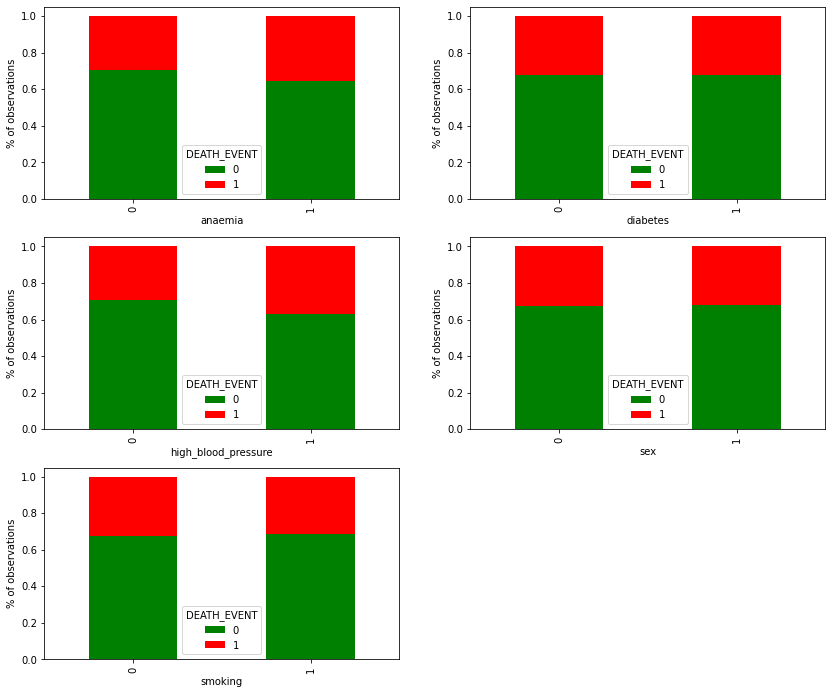

In [11]:
r = c = 0
fig,ax = plt.subplots(3,2,figsize=(14,12))
for n,i in enumerate(cat_features[:-1]):
    ct = pd.crosstab(columns=src[i],index=src["DEATH_EVENT"],normalize="columns")
    ct.T.plot(kind="bar",stacked=True,color=["green","red"],ax=ax[r,c])
    ax[r,c].set_ylabel("% of observations")
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

<h3>The above bar plots doesn't show a strong relationship among categorical variables and target variables as seen in the chi-square tests</h3>
<h3>Boxplots are a one of the best ways to view relationships between numerical and categorical variables. Hence, we'll use them to find the relationships amomg numerical and target variables.</h3>


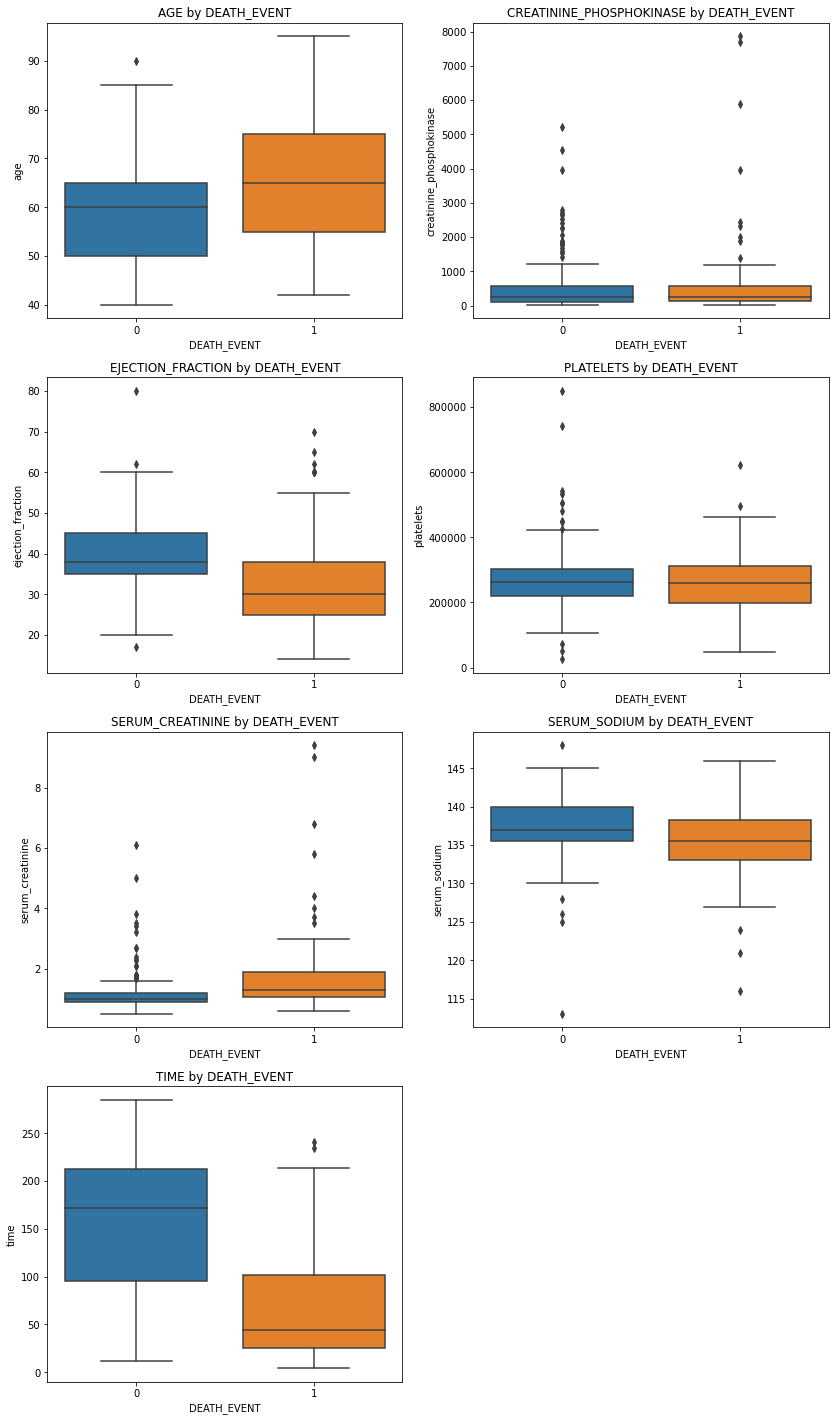

In [12]:
r = c = 0
fig,ax = plt.subplots(4,2,figsize=(14,25))
for n,i in enumerate(num_features):
    sns.boxplot(x="DEATH_EVENT",y=i,data=src,ax=ax[r,c])
    ax[r,c].set_title(i.upper()+" by "+"DEATH_EVENT")
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

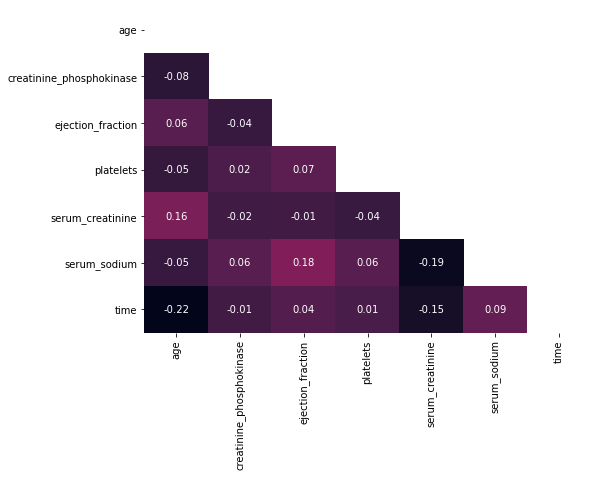

In [13]:
fig = plt.figure(figsize=(8,6))
sns.heatmap(src[num_features].corr(),annot=True,fmt=".2f",mask=np.triu(src[num_features].corr()),cbar=False)
plt.show()

The heatmap below shows no relationship among input features

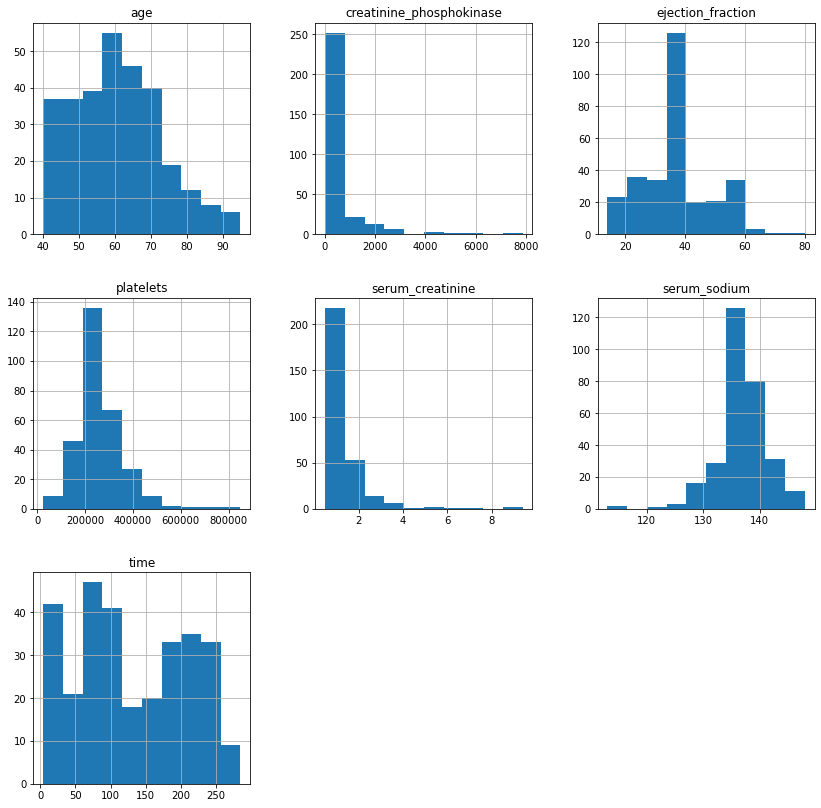

In [14]:
src[num_features].hist(figsize=(14,14))
plt.show();

In [15]:
X = src.iloc[:,:-1]
y = src.iloc[:,-1]

<a id="feature_selection"></a><h1>Feature Selection</h1>

<h3>Finding feature importance with RandomForestClassifier.</h3>

'time' is the most influential variable as it can be seen from the earlier boxplot.

'serum_creatinine', 'ejection_fraction', 'age', 'creatinine_phosphokinase', 'platelets', 'serum_sodium' are looking important in the specified order. All these numerical features and as we saw from the chi-square tests earlier, the categorical features are not so important.

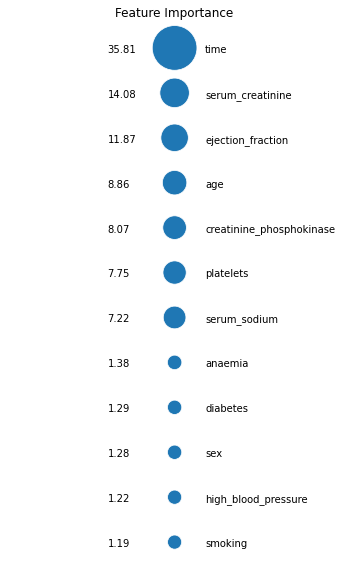

In [16]:
rf = RandomForestClassifier(n_estimators=5000,random_state=11)
rf.fit(X,y)
feat_imp = pd.DataFrame(rf.feature_importances_)
feat_imp.index = pd.Series(src.iloc[:,:-1].columns)
feat_imp = (feat_imp*100).copy().sort_values(by=0,ascending=False)
feat_imp = feat_imp.reset_index()
feat_imp.columns = ["Feature","Importance_score"]

fig = plt.figure(figsize=(6,10))
sns.scatterplot(data=feat_imp,x=5,y=np.linspace(100,0,12),size="Importance_score",sizes=(200,2000),legend=False)
for i,feat,imp in zip(np.linspace(100,0,12),feat_imp["Feature"],feat_imp["Importance_score"]):
    plt.text(x=5.05,y=i-1,s=feat)
    plt.text(x=4.89,y=i-1,s=np.round(imp,2))
plt.axis("off")
plt.title("Feature Importance")
plt.show()

Once we are done with finding the feature importance, we need to identify a threshold for feature importance. It is clear that we can choose 7.222778 can be chosen as threshold. But I want to find a threshold by building a model by eliminating one least important feature at a time till the feature serum_sodium. Then select a set of features with best score.

Since the class is moderately imbalanced, F1 score would be an appropriate metric instead of accuracy.

<h2>Training the model without SMOTE</h2>

<h3>First we train the model without using SMOTE to get an idea of the score and also find the threshold for feature importance scores

In [17]:
for var in np.arange(feat_imp.shape[0],6,-1):
    X_new = X[feat_imp.iloc[:var,0]].copy()
    X_train, X_test, y_train,y_test = train_test_split(X_new,y,test_size=0.2,random_state=11)
    final_rf = RandomForestClassifier(random_state=11)
    gscv = GridSearchCV(estimator=final_rf,param_grid={
        "n_estimators":[100,500,1000,5000],
        "criterion":["gini","entropy"]
    },cv=5,n_jobs=-1,scoring="f1_weighted")

    gscv.fit(X_train,y_train)
    print(str(var)+" variables:  "+str(gscv.best_estimator_)+"  F1 score: "+str(gscv.best_score_))

12 variables:  RandomForestClassifier(n_estimators=500, random_state=11)  F1 score: 0.8340649678089506
11 variables:  RandomForestClassifier(n_estimators=5000, random_state=11)  F1 score: 0.8263002529863771
10 variables:  RandomForestClassifier(n_estimators=500, random_state=11)  F1 score: 0.8306172323033565
9 variables:  RandomForestClassifier(random_state=11)  F1 score: 0.8410399170248493
8 variables:  RandomForestClassifier(n_estimators=1000, random_state=11)  F1 score: 0.8435036680809833
7 variables:  RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=11)  F1 score: 0.8333208818231832


Model with top 8 variables has the best score. Hence the threshold is 1.375402. We'll include all the features with importance above the threshold. So let's build a model with the 8 variables

In [18]:
X_new = X[feat_imp.iloc[:8,0]].copy()
X_train, X_test, y_train,y_test = train_test_split(X_new,y,test_size=0.2,random_state=11)
final_rf = RandomForestClassifier(random_state=11)
gscv = GridSearchCV(estimator=final_rf,param_grid={
    "n_estimators":[100,500,1000,5000],
    "criterion":["gini","entropy"]
},cv=5,n_jobs=-1,scoring="f1_weighted")

gscv.fit(X_train,y_train)
FINAL_MODEL_NO_SMOTE = gscv.best_estimator_

In [19]:
FINAL_MODEL_NO_SMOTE.score(X_train,y_train)

1.0

In [20]:
train_pred = FINAL_MODEL_NO_SMOTE.predict(X_train)
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00        79

    accuracy                           1.00       239
   macro avg       1.00      1.00      1.00       239
weighted avg       1.00      1.00      1.00       239



The model built without SMOTE has a score of 1 on training set and shows the model is overfitting the training data. Further hyperparameter tuning like max_depth may prevent the trees from overfitting.

In [21]:
FINAL_MODEL_NO_SMOTE.score(X_test,y_test)

0.8666666666666667

<h3>As expected the model is overfit to the training set as the test set score is 0.86 and the CV score is 0.84 vs the training set score of 1.

<a id="smote"></a><h1>Handling Imbalanced Class Problem With SMOTE</h1>

<h3>SMOTE stands for 'Synthetic Minority Oversampling Technique' is an oversampling technique of the minority category. SMOTE generates synthetic samples to brings the count of the categories in the training target variable to the same number.</h3> Below is a plot to show synthetic samples/examples generated using SMOTE in comparison with original samples/examples

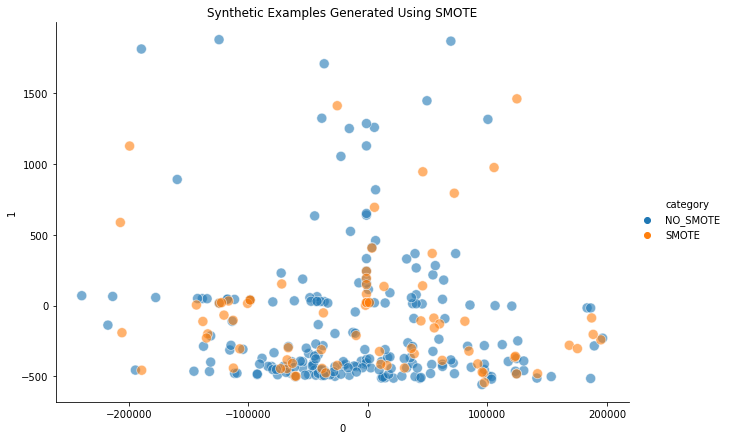

In [22]:
X_new = X.copy()
X_train, X_test, y_train,y_test = train_test_split(X_new,y,test_size=0.2,random_state=11)
smote = SMOTE(random_state = 11) 
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)


X_train.insert(12,"category","NO_SMOTE")
X_train_smote.insert(12,"category","SMOTE")


final_X = X_train.append(X_train_smote).copy()
final_X.drop_duplicates(subset=list(final_X.columns[:-1]),inplace=True)
final_cat = final_X["category"]
final_X.drop(columns="category",inplace=True)
pca = PCA(n_components=2)
final_X = pd.DataFrame(pca.fit_transform(final_X))
final_X["category"] = list(final_cat)
final_X = final_X.loc[(final_X[0]<=200000) & (final_X[1]<=2000),:].copy()
sns.relplot(data=final_X,x=0,y=1,hue="category",alpha=0.6,s=100,height=6,aspect=1.5)
plt.title("Synthetic Examples Generated Using SMOTE");

In [23]:
for var in np.arange(feat_imp.shape[0],6,-1):
    X_new = X[feat_imp.iloc[:var,0]].copy()
    X_train, X_test, y_train,y_test = train_test_split(X_new,y,test_size=0.2,random_state=11)
    smote = SMOTE(random_state = 11) 
    X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
    final_rf = RandomForestClassifier(random_state=11)
    
    
    gscv = GridSearchCV(estimator=final_rf,param_grid={
        "n_estimators":[100,500,1000,5000],
        "criterion":["gini","entropy"]
    },cv=5,n_jobs=-1,scoring="f1_weighted")

    gscv.fit(X_train_smote,y_train_smote)
    print(str(var)+" variables:  "+str(gscv.best_estimator_)+"  F1 score: "+str(gscv.best_score_))

12 variables:  RandomForestClassifier(criterion='entropy', random_state=11)  F1 score: 0.8873161575080999
11 variables:  RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=11)  F1 score: 0.8842412152469079
10 variables:  RandomForestClassifier(random_state=11)  F1 score: 0.8839385437774332
9 variables:  RandomForestClassifier(random_state=11)  F1 score: 0.887216678453329
8 variables:  RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=11)  F1 score: 0.8934649174455945
7 variables:  RandomForestClassifier(criterion='entropy', random_state=11)  F1 score: 0.8840295095155696


As seen above, SMOTE has brought an improvement in the model score.

The best model is the one with top 8 variables

Below we build the final model with 8 variables

<a id="rf"></a><h1>Training RandomForestClassifier & Hyperparameter Tuning With GridSearchCV</h1>

In [24]:
X_new = X[feat_imp.iloc[:8,0]].copy()
X_train, X_test, y_train,y_test = train_test_split(X_new,y,test_size=0.2,random_state=11)
smote = SMOTE(random_state = 11) 
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
final_rf = RandomForestClassifier(random_state=11)
gscv = GridSearchCV(estimator=final_rf,param_grid={
    "n_estimators":[100,500,1000,5000],
    "criterion":["gini","entropy"]
},cv=5,n_jobs=-1,scoring="f1_weighted")

gscv.fit(X_train_smote,y_train_smote)
FINAL_MODEL = gscv.best_estimator_

In [25]:
FINAL_MODEL.score(X_train_smote,y_train_smote)

1.0

In [26]:
train_pred = FINAL_MODEL.predict(X_train_smote)
print(classification_report(y_train_smote,train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       160

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320



The training set score is again 1. Further hyperparameter tuning like max_depth may prevent the trees from overfitting.

In [27]:
FINAL_MODEL.score(X_test,y_test) #Test set score

0.9

In [28]:
pred = FINAL_MODEL.predict(X_test)

In [29]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.93        43
           1       0.76      0.94      0.84        17

    accuracy                           0.90        60
   macro avg       0.87      0.91      0.88        60
weighted avg       0.91      0.90      0.90        60



The test set scores and the CV scores of model trained on data with SMOTE applied are better compared to the model trained without SMOTE. So, we'll consider the model trained on data with SMOTE applied as the final model.

<a id="lc"></a><h1>Identifying Overfitting With Learning Curve</h1>
<h3>Learning curve helps us identify bias and variance and also helps us confirm if adding more training data will improve the performance on unseen data or not

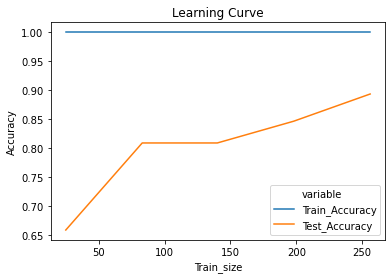

In [30]:
train_size,train_acc,test_acc = learning_curve(FINAL_MODEL, X_train_smote,y_train_smote,cv=5)
learn_df = pd.DataFrame({"Train_size":train_size,"Train_Accuracy":train_acc.mean(axis=1),"Test_Accuracy":test_acc.mean(axis=1)}).melt(id_vars="Train_size")
sns.lineplot(x="Train_size",y="value",data=learn_df,hue="variable")
plt.title("Learning Curve")
plt.ylabel("Accuracy");

<h3>The model is overfit to the train set despite</h3>

<h3>
<ol>
    <li>Using Ensembling</li>
    <li>Reducing the number of features</li>
    </ol>
    
Hence, overfitting might be because of a very small training set used. As seen from the learning curve, adding additional examples to the training set will improve the model performance on unseen data. There has been an improvement in the CV score and test set score after adding synthetic examples using SMOTE. Further hyperparameter tuning may also be explored to prevent the classifier from overfitting.  

The predictions of the final model with 8 variables and SMOTE

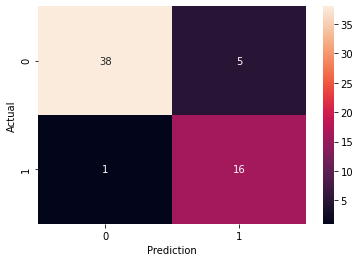

In [31]:
sns.heatmap(confusion_matrix(y_test,pred),annot=True)
plt.ylabel("Actual")
plt.xlabel("Prediction");

<a id="oof"></a><h1>Overcoming Overfitting</h1>

<h3>As discussed above, adding training examples can prevent overfitting, but we have no option to add more training examples. Hence, we need to do something else. We'll discuss few ways of overcoming overfitting a model to smaller datasets</h3>

<h3>Using a simpler model on small training sets is one of the ways to prevent overfitting. But we're to learn how to overcome overfitting RandomForest to smaller datasets. Tuning few hyperparameters helps us overcome overfitting

In [32]:
X_new = X[feat_imp.iloc[:8,0]].copy()
X_train, X_test, y_train,y_test = train_test_split(X_new,y,test_size=0.2,random_state=11)
smote = SMOTE(random_state = 11) 
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
final_rf = RandomForestClassifier(random_state=11)
gscv = GridSearchCV(estimator=final_rf,param_grid={
    "n_estimators":[5000,7000],
    "criterion":["gini","entropy"],
    "max_depth":[3,5,7],
    "min_samples_split":[80,100],
    "min_samples_leaf":[40,50],
},cv=5,n_jobs=-1,scoring="f1_weighted")

gscv.fit(X_train_smote,y_train_smote)
FINAL_MODEL = gscv.best_estimator_

In [33]:
FINAL_MODEL

RandomForestClassifier(max_depth=3, min_samples_leaf=40, min_samples_split=100,
                       n_estimators=7000, random_state=11)

In [34]:
gscv.best_score_

0.8468253789221531

In [35]:
FINAL_MODEL.score(X_train_smote,y_train_smote)

0.859375

<h3>Now we see the model is not overfit to the training set. This is because:</h3>
    
<h4><ol><li>We selected a large number for n_estimators, which grows more trees, hence preventing overfitting.</li>
<li>We prevented the tree to grow by choosing a low number for 'max_depth'.</li>
<li>We selected large numbers for 'max_samples_split' and 'max_samples_leaf', which ensures the leaf has a good number of samples.

In [36]:
train_pred = FINAL_MODEL.predict(X_train_smote)
print(classification_report(y_train_smote,train_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       160
           1       0.85      0.87      0.86       160

    accuracy                           0.86       320
   macro avg       0.86      0.86      0.86       320
weighted avg       0.86      0.86      0.86       320



In [37]:
FINAL_MODEL.score(X_test,y_test) #Test set score

0.8833333333333333

<h3>Training set score is close to cross validation and test set score, showing that the model is not overfit to the training set.

<h2>Metrics of the final model

In [38]:
pred = FINAL_MODEL.predict(X_test)

In [39]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91        43
           1       0.73      0.94      0.82        17

    accuracy                           0.88        60
   macro avg       0.85      0.90      0.87        60
weighted avg       0.90      0.88      0.89        60



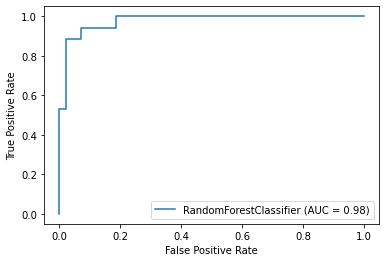

In [40]:
plot_roc_curve(FINAL_MODEL, X_test, y_test)
plt.show()

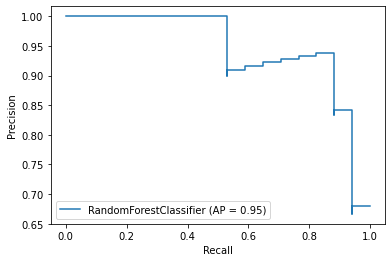

In [41]:
plot_precision_recall_curve(FINAL_MODEL, X_test, y_test)
plt.show()

<h3>As seen in the ROC curve above, this model has a good True Positive Rate (TPR) which is important for a model used for medical diagnosis

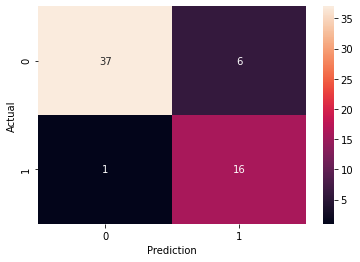

In [42]:
sns.heatmap(confusion_matrix(y_test,pred),annot=True)
plt.ylabel("Actual")
plt.xlabel("Prediction");